In [1]:
# # For tips on running notebooks in Google Colab, see
# # https://pytorch.org/tutorials/beginner/colab
# %matplotlib inline

Transfer Learning for Computer Vision Tutorial
==============================================

**Author**: [Sasank Chilamkurthy](https://chsasank.github.io)

In this tutorial, you will learn how to train a convolutional neural
network for image classification using transfer learning. You can read
more about the transfer learning at [cs231n
notes](https://cs231n.github.io/transfer-learning/)

Quoting these notes,

> In practice, very few people train an entire Convolutional Network
> from scratch (with random initialization), because it is relatively
> rare to have a dataset of sufficient size. Instead, it is common to
> pretrain a ConvNet on a very large dataset (e.g. ImageNet, which
> contains 1.2 million images with 1000 categories), and then use the
> ConvNet either as an initialization or a fixed feature extractor for
> the task of interest.

These two major transfer learning scenarios look as follows:

-   **Finetuning the ConvNet**: Instead of random initialization, we
    initialize the network with a pretrained network, like the one that
    is trained on imagenet 1000 dataset. Rest of the training looks as
    usual.
-   **ConvNet as fixed feature extractor**: Here, we will freeze the
    weights for all of the network except that of the final fully
    connected layer. This last fully connected layer is replaced with a
    new one with random weights and only this layer is trained.


In [2]:
# License: BSD
# Author: Sasank Chilamkurthy

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torchvision.transforms import v2
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory

# cudnn.benchmark = True
plt.ion()   # interactive mode

Load Data
=========

We will use torchvision and torch.utils.data packages for loading the
data.

The problem we\'re going to solve today is to train a model to classify
**ants** and **bees**. We have about 120 training images each for ants
and bees. There are 75 validation images for each class. Usually, this
is a very small dataset to generalize upon, if trained from scratch.
Since we are using transfer learning, we should be able to generalize
reasonably well.

This dataset is a very small subset of imagenet.


In [3]:
# Data augmentation and normalization for training
# Just normalization for validation
img_h_w = 256
data_transforms = {
    'train': v2.Compose([
        v2.ToImage(),
        v2.RandomRotation(20),
        v2.RandomHorizontalFlip(),
        v2.RandomVerticalFlip(),
        v2.Resize(img_h_w, antialias=True),
        # v2.ColorJitter(0.5, 0.5, 0.5, 0.5),
        v2.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
        v2.ToDtype(torch.float32, scale=True),
    ]),
    'val': v2.Compose([
        v2.ToImage(),
        v2.Resize(img_h_w, antialias=True),
        v2.ToDtype(torch.float32, scale=True),
    ]),
}

data_dir = 'dataset'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=16,
                                             shuffle=True , num_workers=2)
               for x in ['train', 'val']}
# dataloaders = {"val": torch.utils.data.DataLoader(image_datasets["val"], batch_size=4, shuffle=False), "train": torch.utils.data.DataLoader(image_datasets["train"], batch_size=16, shuffle=True, num_workers=2)}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

Visualize a few images
======================

Let\'s visualize a few training images so as to understand the data
augmentations.


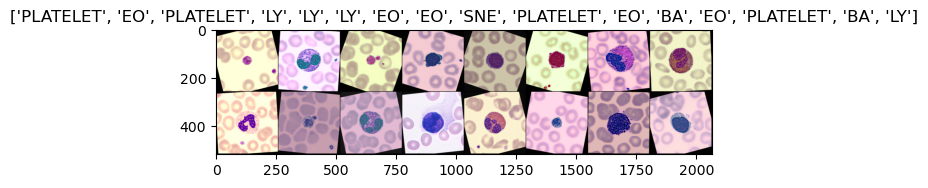

In [4]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    # mean = np.array([0.485, 0.456, 0.406])
    # std = np.array([0.229, 0.224, 0.225])
    # inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

Training the model
==================

Now, let\'s write a general function to train a model. Here, we will
illustrate:

-   Scheduling the learning rate
-   Saving the best model

In the following, parameter `scheduler` is an LR scheduler object from
`torch.optim.lr_scheduler`.


In [5]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_val_acc = 100

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')
    
        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)
                    torch.save(model.state_dict(), "./model_wbc_resnet50.pth")

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))
    return model

Visualizing the model predictions
=================================

Generic function to display predictions for a few images


In [6]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

Finetuning the ConvNet
======================

Load a pretrained model and reset final fully connected layer.


In [7]:
model_ft = models.resnet101(weights='IMAGENET1K_V1')
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
model_ft.fc = nn.Linear(num_ftrs, len(class_names))

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [8]:
# model_ft.load_state_dict(torch.load("ckpts/model_wbc_resnet101_v2.pth"))

In [9]:
visualize_model(model_ft)

KeyboardInterrupt: 

<Figure size 640x480 with 0 Axes>

## Draw the TSNE plot

In [ ]:
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

In [ ]:
model_ft.avgpool.register_forward_hook(get_activation('avgpool'))

In [ ]:
import tqdm
labels = []
outputs = torch.zeros((0,2048))
ii = np.zeros((0,3,img_h_w,img_h_w))
for (inputs, label) in tqdm.tqdm(dataloaders['val'], desc='Running the model inference'):
    images = inputs.to(device)
    labels += list(label.numpy())
 
    output = model_ft.forward(images)
 
    current_outputs = activation['avgpool'].squeeze((2,3)).cpu().numpy()
    outputs = np.concatenate((outputs, current_outputs))
    ii = np.concatenate((ii, inputs))

Running the model inference: 100%|██████████| 72/72 [00:13<00:00,  5.46it/s]


In [ ]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=5, perplexity=20, n_iter=10000)

In [ ]:
%%time
X_2d = tsne.fit_transform(outputs)

CPU times: user 5min 3s, sys: 57.7 ms, total: 5min 3s
Wall time: 12.7 s


In [ ]:
# scale and move the coordinates so they fit [0; 1] range
def scale_to_01_range(x):
    # compute the distribution range
    value_range = (np.max(x) - np.min(x))
 
    # move the distribution so that it starts from zero
    # by extracting the minimal value from all its values
    starts_from_zero = x - np.min(x)
 
    # make the distribution fit [0; 1] by dividing by its range
    return starts_from_zero / value_range
 
# extract x and y coordinates representing the positions of the images on T-SNE plot
tx = X_2d[:, 0]
ty = X_2d[:, 1]
 
tx = scale_to_01_range(tx)
ty = scale_to_01_range(ty)

In [ ]:
colors = 'r', 'g', 'b', 'c', 'm', 'y', 'k', 'w', 'orange', 'purple'
colors = colors[:len(np.unique(labels))]
colors_per_class = {}
for i, l in enumerate(np.unique(labels)):
    colors_per_class[l] = colors[i]

In [ ]:
colors_per_class = {
        0 : [254, 202, 87],
        1 : [255, 107, 107],
        2 : [10, 189, 227],
        3 : [255, 159, 243],
        4 : [16, 172, 132],
        5 : [128, 80, 128],
        6 : [255, 165, 0],
        7 : [0, 128, 0],
        8 : [0, 0, 128],
        9 : [128, 0, 0],
    }

In [ ]:
len(labels)

1141

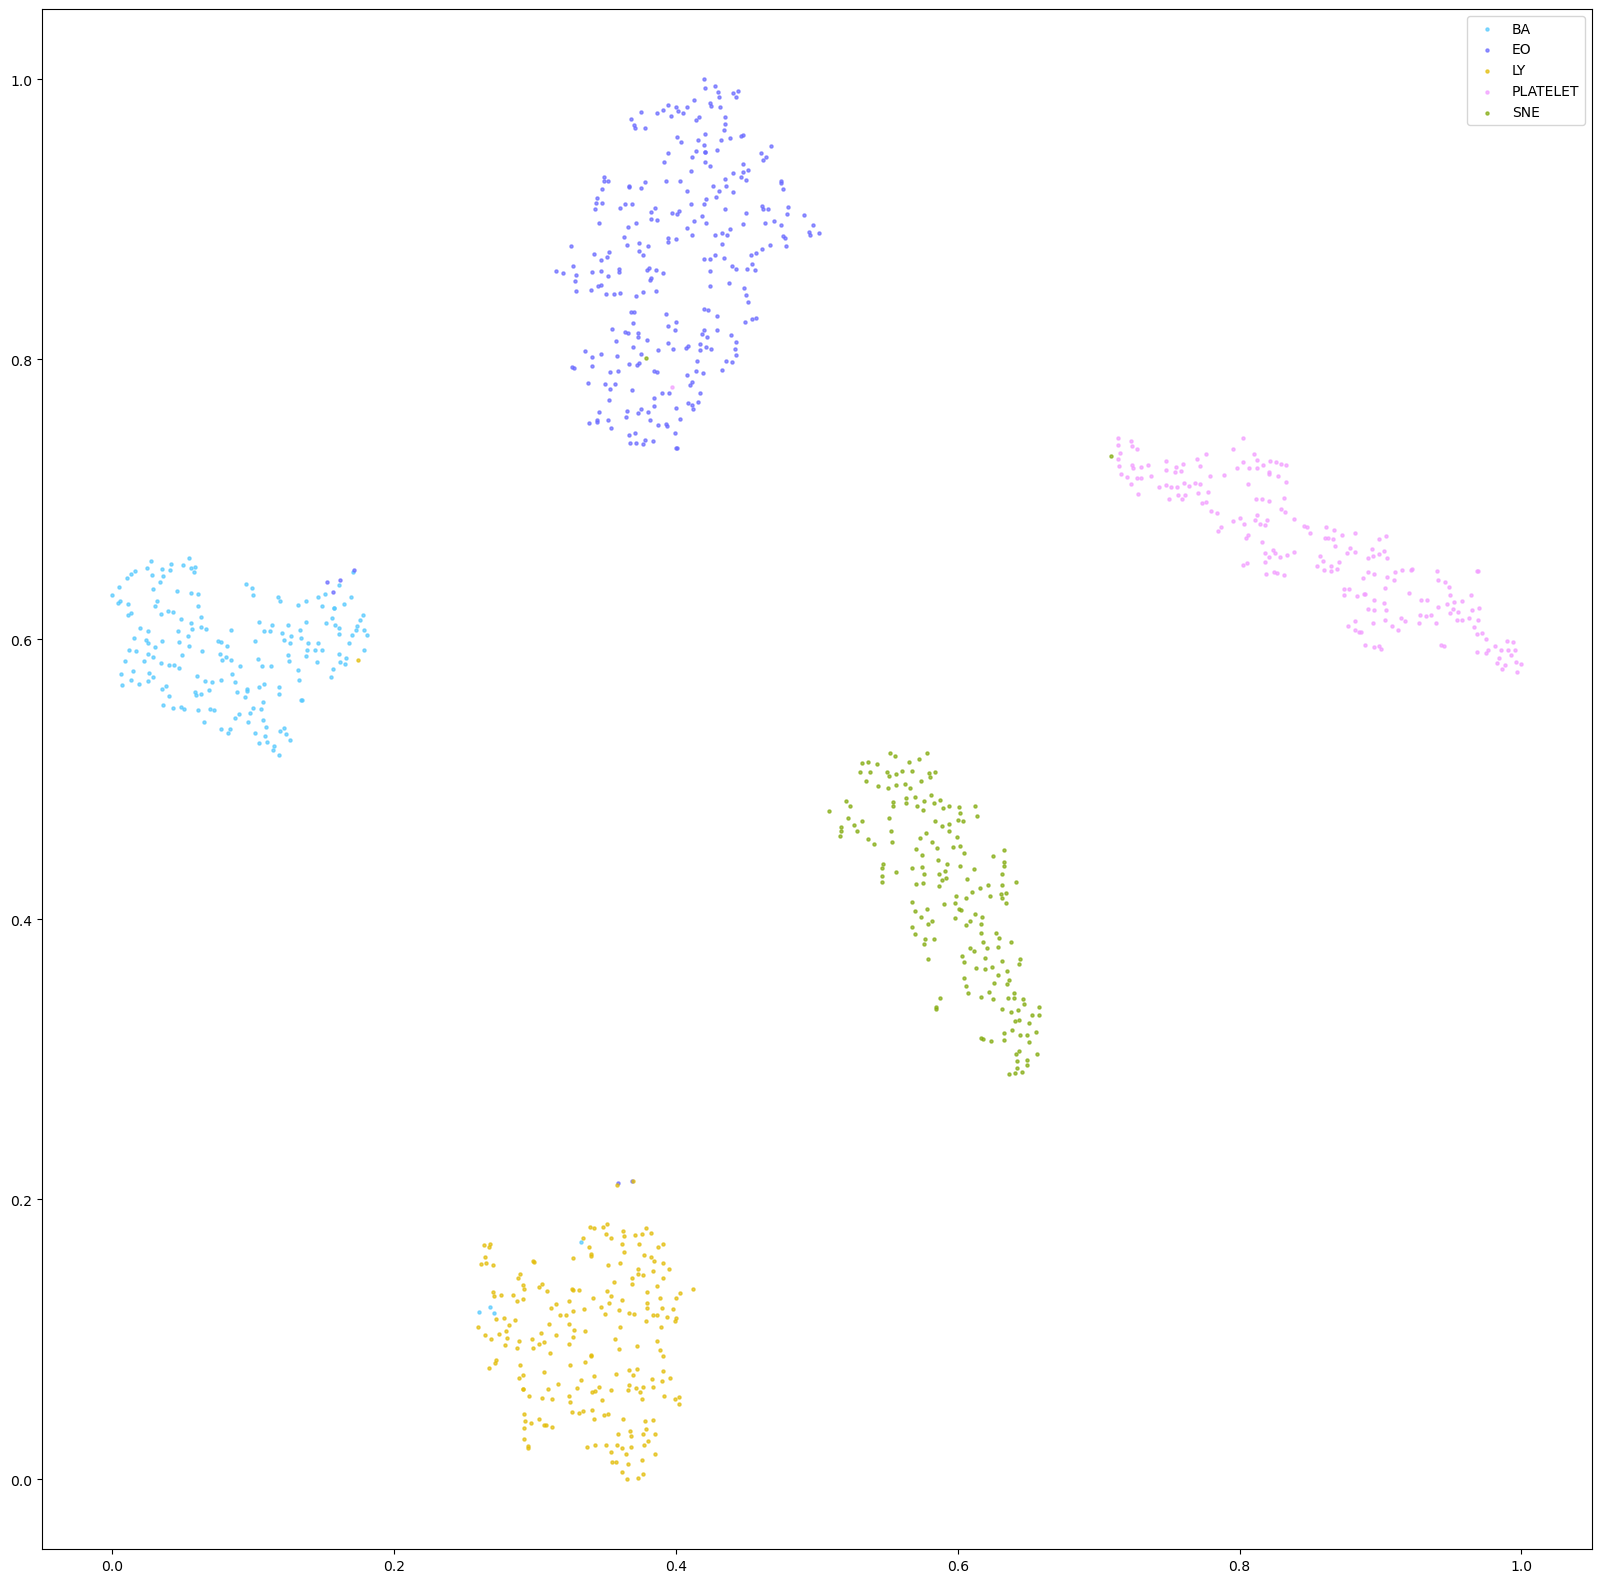

In [ ]:
# initialize a matplotlib plot
fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(111)
 
# for every class, we'll add a scatter plot separately
for label in np.unique(labels):
    # find the samples of the current class in the data
    indices = [i for i, l in enumerate(labels) if l == label]
 
    # extract the coordinates of the points of this class only
    current_tx = np.take(tx, indices)
    current_ty = np.take(ty, indices)
 
    # convert the class color to matplotlib format
    # color = colors_per_class[label]
    color = np.array([colors_per_class[label][::-1]], dtype=np.float16) / 255
 
    # add a scatter plot with the corresponding color and label
    ax.scatter(current_tx, current_ty, c=color, label=class_names[label], alpha=0.7, s=5)
 
# build a legend using the labels we set previously
ax.legend(loc='best')
 
# finally, show the plot

In [ ]:
def compute_plot_coordinates(image, x, y, image_centers_area_size, offset):
    image_height, image_width, _ = image.shape
 
    # compute the image center coordinates on the plot
    center_x = int(image_centers_area_size * x) + offset
 
    # in matplotlib, the y axis is directed upward
    # to have the same here, we need to mirror the y coordinate
    center_y = int(image_centers_area_size * (1 - y)) + offset
 
    # knowing the image center,
    # compute the coordinates of the top left and bottom right corner
    tl_x = center_x - int(image_width / 2)
    tl_y = center_y - int(image_height / 2)
 
    br_x = tl_x + image_width
    br_y = tl_y + image_height
 
    return tl_x, tl_y, br_x, br_y
 


In [ ]:
def scale_image(image, max_image_size):
    image_height, image_width, _ = image.shape

    scale = max(1, image_width / max_image_size, image_height / max_image_size)
    image_width = int(image_width / scale)
    image_height = int(image_height / scale)

    image = cv2.resize(image, (image_width, image_height))
    return image


def draw_rectangle_by_class(image, label):
    image_height, image_width, _ = image.shape

    # get the color corresponding to image class
    color = colors_per_class[label]
    image = cv2.rectangle(image, (0, 0), (image_width - 1, image_height - 1), color=color[::-1], thickness=5)

    return image

In [ ]:
import cv2

In [ ]:
ii.shape

(1141, 3, 256, 256)

In [ ]:
# we'll put the image centers in the central area of the plot
# and use offsets to make sure the images fit the plot
plot_size = 1000
max_image_size = 100
offset = max_image_size // 2
image_centers_area_size = plot_size - 2 * offset

# init the plot as white canvas
tsne_plot = 255 * np.ones((plot_size, plot_size, 3), np.uint8)
 
# now we'll put a small copy of every image to its corresponding T-SNE coordinate
i = 0
for image, label, x, y in tqdm.tqdm(
        zip(ii, labels, tx, ty),
        desc='Building the T-SNE plot',
        total=len(dataloaders['val'])
):
    image = image.transpose((1, 2, 0))
    # print(image.shape, label)
    # image = cv2.cvtColor((image*255).astype(np.uint8), cv2.COLOR_RGB2BGR)
    image = (image*255).astype(np.uint8)
 
    # scale the image to put it to the plot
    image = scale_image(image, max_image_size)
 
    # draw a rectangle with a color corresponding to the image class
    image = draw_rectangle_by_class(image, label)
 
    # compute the coordinates of the image on the scaled plot visualization
    tl_x, tl_y, br_x, br_y = compute_plot_coordinates(image, x, y, image_centers_area_size, offset)
 
    # put the image to its t-SNE coordinates using numpy sub-array indices
    tsne_plot[tl_y:br_y, tl_x:br_x, :] = image
    i += 1
    if i > 500:
        break
 

Building the T-SNE plot: 500it [00:00, 2279.65it/s]            


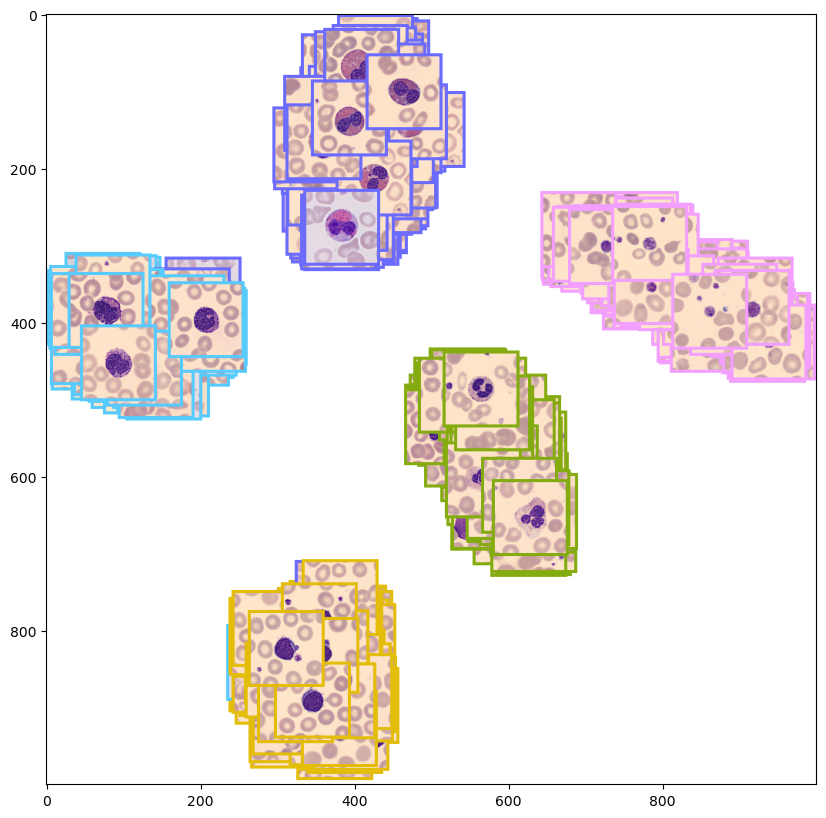

In [ ]:
# plt.imshow(cv2.cvtColor(tsne_plot, cv2.COLOR_BGR2RGB))
plt.figure(figsize=(10, 10))
plt.imshow(tsne_plot)
plt.savefig("tsne_plot.pdf")
plt.show()

Building the T-SNE plot: 1000it [00:00, 2025.50it/s]           


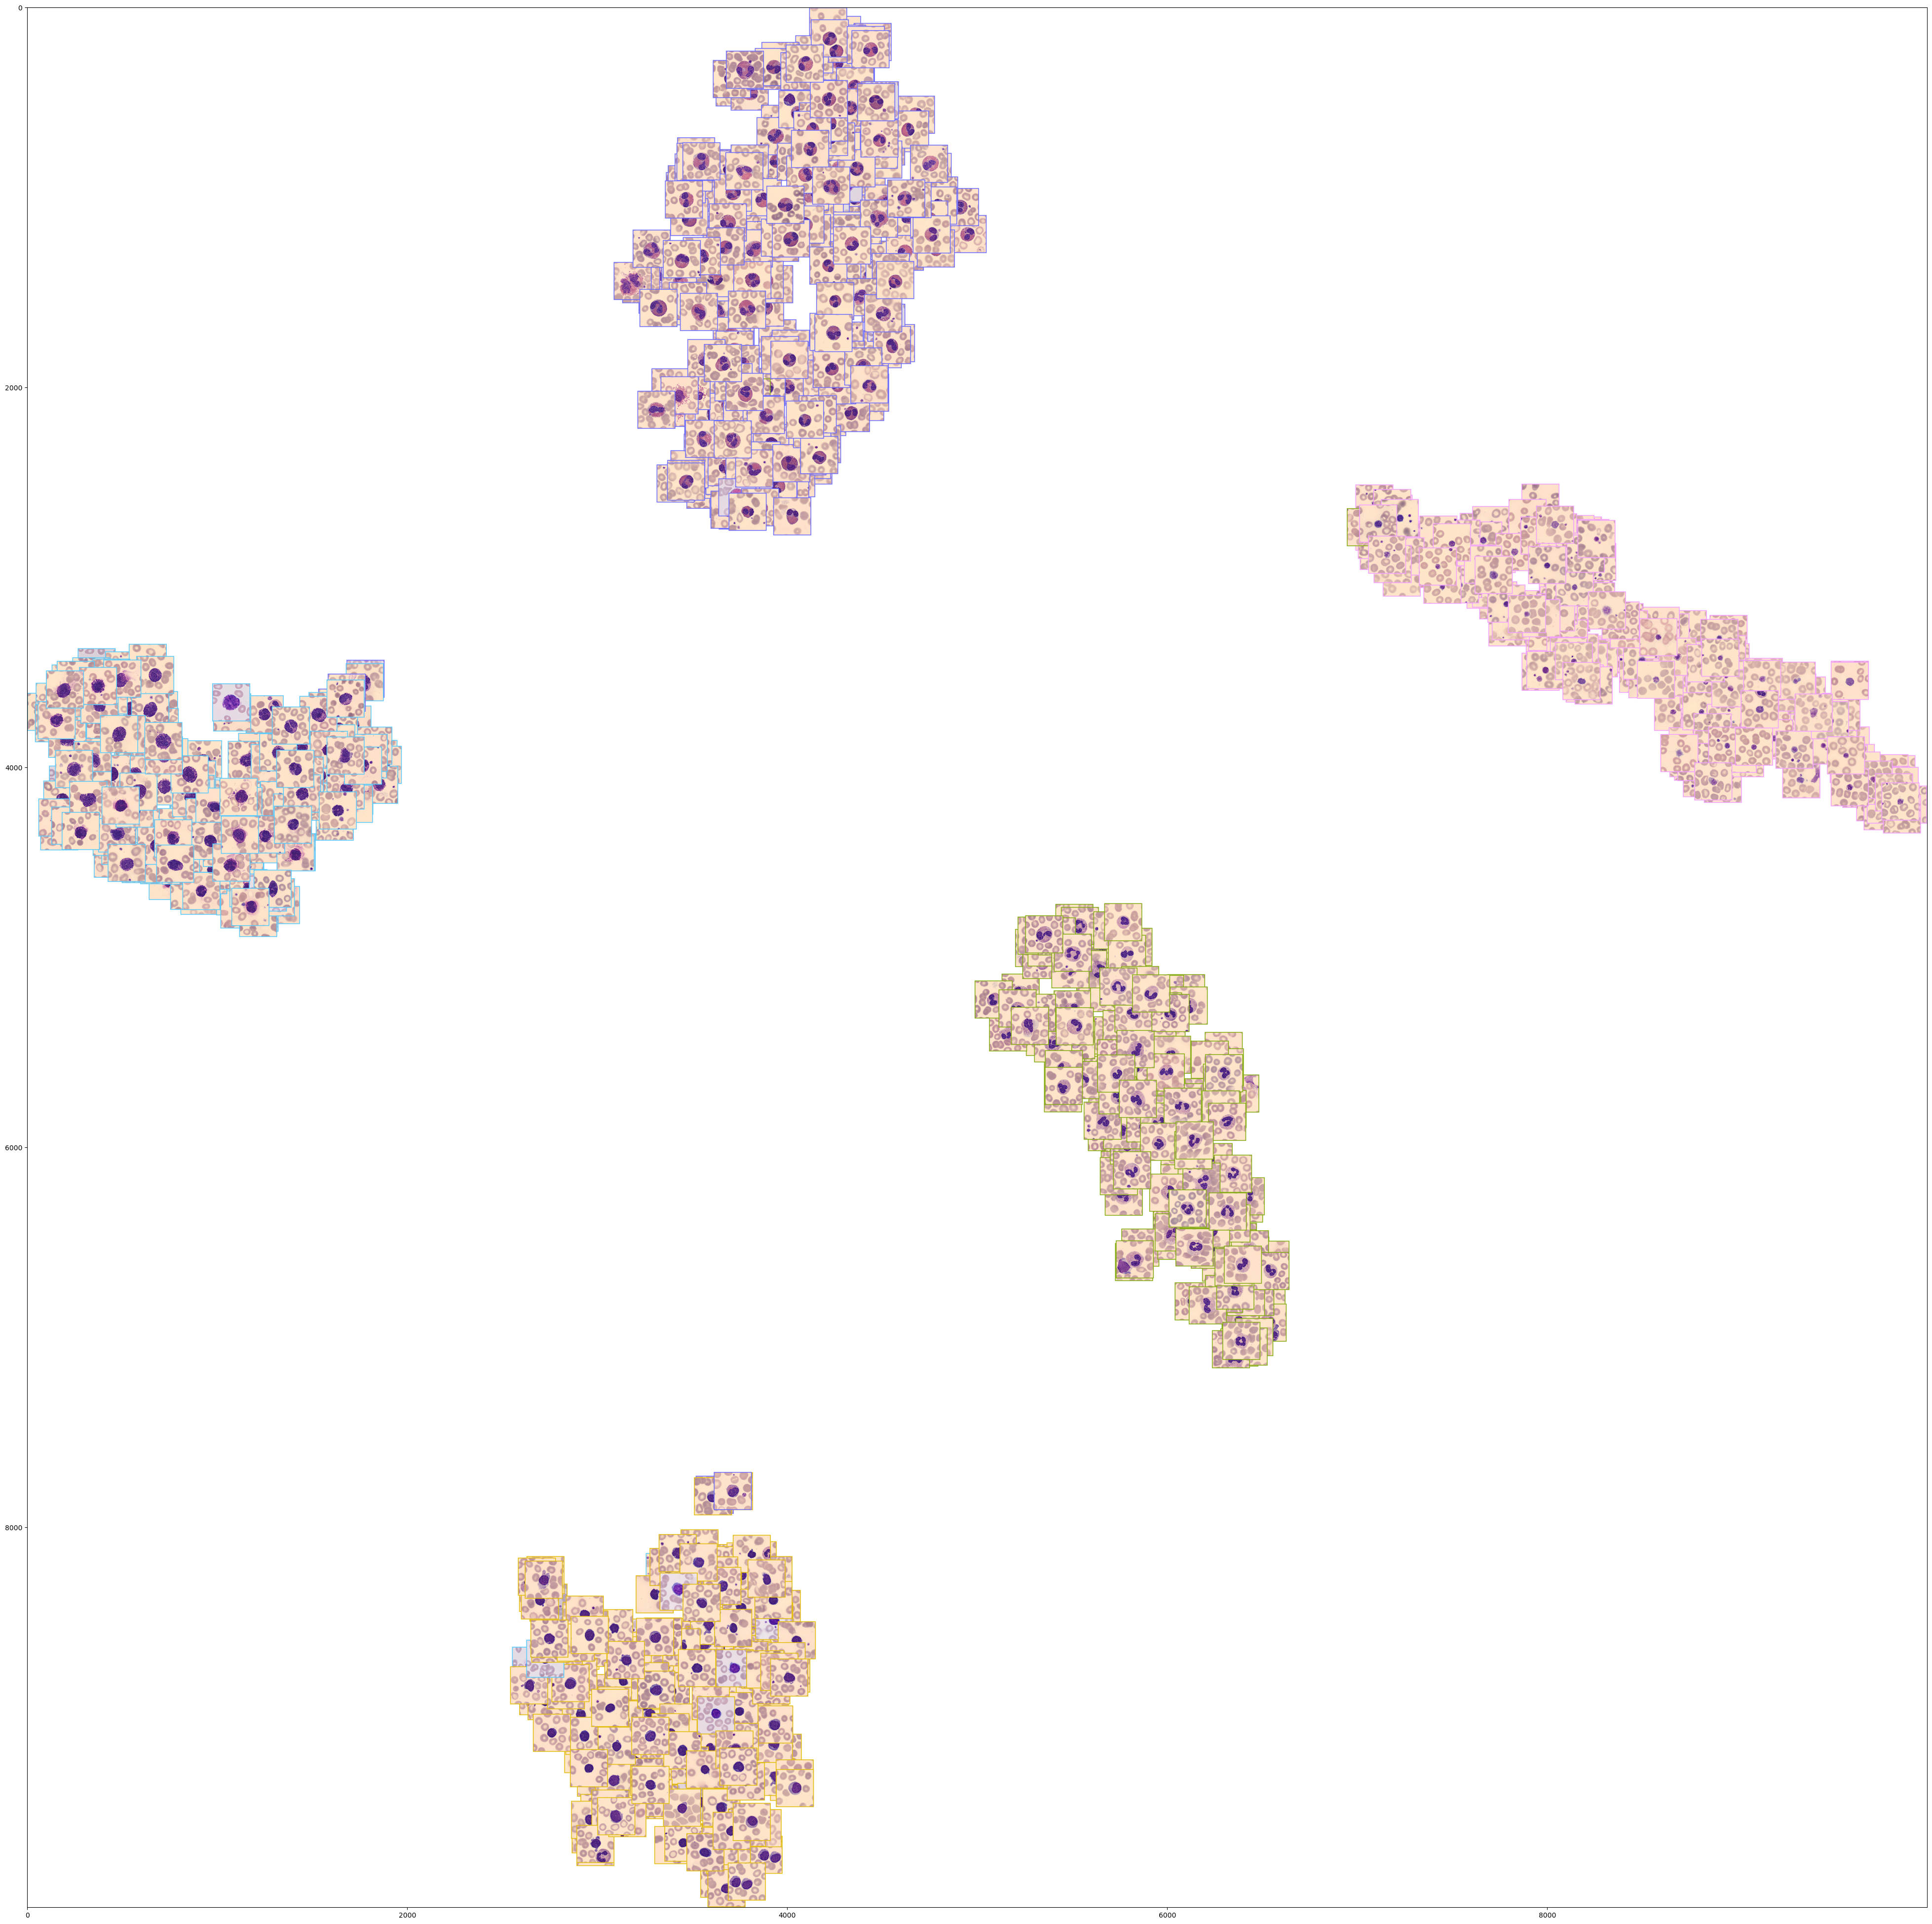

In [ ]:
# we'll put the image centers in the central area of the plot
# and use offsets to make sure the images fit the plot
plot_size = 10000
max_image_size = 200
offset = max_image_size // 2
image_centers_area_size = plot_size - 2 * offset

# init the plot as white canvas
tsne_plot = 255 * np.ones((plot_size, plot_size, 3), np.uint8)
 
# now we'll put a small copy of every image to its corresponding T-SNE coordinate
i = 0
for image, label, x, y in tqdm.tqdm(
        zip(ii, labels, tx, ty),
        desc='Building the T-SNE plot',
        total=len(dataloaders['val'])
):
    image = image.transpose((1, 2, 0))
    # print(image.shape, label)
    # image = cv2.cvtColor((image*255).astype(np.uint8), cv2.COLOR_RGB2BGR)
    image = (image*255).astype(np.uint8)
 
    # scale the image to put it to the plot
    image = scale_image(image, max_image_size)
 
    # draw a rectangle with a color corresponding to the image class
    image = draw_rectangle_by_class(image, label)
 
    # compute the coordinates of the image on the scaled plot visualization
    tl_x, tl_y, br_x, br_y = compute_plot_coordinates(image, x, y, image_centers_area_size, offset)
 
    # put the image to its t-SNE coordinates using numpy sub-array indices
    tsne_plot[tl_y:br_y, tl_x:br_x, :] = image
    i += 1
    if i > 1000:
        break

# plt.imshow(cv2.cvtColor(tsne_plot, cv2.COLOR_BGR2RGB))
plt.figure(figsize=(50, 50))
plt.imshow(tsne_plot)
plt.savefig("tsne_plot_large.pdf")

In [ ]:
# # target_ids = range(labels)

# from matplotlib import pyplot as plt
# plt.figure(figsize=(6, 5))
# colors = 'r', 'g', 'b', 'c', 'm', 'y', 'k', 'w', 'orange', 'purple'
# colors = colors[:len(np.unique(labels))]
# for i, c, label in zip(np.unique(labels), colors, np.unique(labels)):
#     plt.scatter(X_2d[labels == i, 0], X_2d[labels == i, 1], c=c, label=class_names[label], alpha=0.5, s=10)

# plt.legend()
# plt.show()